In [37]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import altair as alt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA as SklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.impute import SimpleImputer
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from sklearn.preprocessing import normalize

import project_fuctions as functions

try:
    from scipy import sparse
except Exception:
    sparse = None

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

### Data Loading

In [38]:
dataset = "data/merge_dataset_cleaned.csv"
print(f"Caricamento di '{dataset}'...")

try:
    # Azione di Caricamento
    df = pd.read_csv(dataset)

    print(f"\nSUCCESSO: DataFrame caricato con successo.")
    print(f"Shape: {df.shape}")
    print("Il DataFrame è ora pronto per la 'Data Transformation'.")

except FileNotFoundError:
    print(f"\nERRORE: File non trovato.")
    print(f"Assicurati che il file '{dataset}' esista e che il percorso sia corretto.")
except Exception as e:
    print(f"\nERRORE: Si è verificato un errore durante il caricamento del file.")
    print(f"Dettagli errore: {e}")

# Ispezioniamo rapidamente l'intestazione e i tipi di dati per confermare
if 'df' in locals():
    print("\n--- Ispezione Post-Caricamento ---")
    print("Prime 5 righe:")
    display(df.head())
    print("\nTipi di dati (Dtypes):")
    df.info()

Caricamento di 'data/merge_dataset_cleaned.csv'...

SUCCESSO: DataFrame caricato con successo.
Shape: (11032, 53)
Il DataFrame è ora pronto per la 'Data Transformation'.

--- Ispezione Post-Caricamento ---
Prime 5 righe:


,id,id_artist,full_title,featured_artists,primary_artist,language,stats_pageviews,swear_IT,swear_EN,swear_IT_words,...,country,latitude,longitude,popularity_missing_flag,n_tokens,n_sentences,lexical_density,tokens_per_sent,char_per_tok,album_release_date
0,TR934808,ART04205421,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),"Ernia, Guè",Rosa Chemical,it,196033.0,13,6,"['cazzo', 'cesso', 'coglioni', 'figa', 'merda'...",...,Italia,45.068046,7.57762,0,702,102,0.562678,6.882353,4.133903,2021-04-09
1,TR760029,ART04205421,POLKA by Rosa Chemical (Ft. Thelonious B.),Thelonious B.,Rosa Chemical,it,164450.0,9,12,"['cazzo', 'culo', 'frocio', 'puttana', 'sega',...",...,Italia,45.068046,7.57762,0,480,58,0.506250,8.275862,4.093750,2021-04-09
2,TR916821,ART04205421,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,"MamboLosco, RADICAL",Rosa Chemical,it,58313.0,16,12,"['bastardo', 'cazzo', 'culo', 'merda', 'troia']",...,Italia,45.068046,7.57762,0,602,88,0.496678,6.840909,3.980066,2021-04-09
3,TR480968,ART04205421,CEO by Rosa Chemical (Ft. Taxi B),Taxi B,Rosa Chemical,it,39890.0,8,3,"['cazzo', 'culo', 'fottere', 'merda', 'pompino...",...,Italia,45.068046,7.57762,0,327,37,0.608563,8.837838,4.039755,2025-05-16
4,TR585039,ART04205421,LONDRA by Rosa Chemical (Ft. Rkomi),Rkomi,Rosa Chemical,it,35432.0,1,0,['cazzo'],...,Italia,45.068046,7.57762,0,350,48,0.525714,7.291667,3.891429,2020-05-28



Tipi di dati (Dtypes):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11032 entries, 0 to 11031
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11032 non-null  object 
 1   id_artist                11032 non-null  object 
 2   full_title               11032 non-null  object 
 3   featured_artists         3483 non-null   object 
 4   primary_artist           11032 non-null  object 
 5   language                 11032 non-null  object 
 6   stats_pageviews          4641 non-null   float64
 7   swear_IT                 11032 non-null  int64  
 8   swear_EN                 11032 non-null  int64  
 9   swear_IT_words           11032 non-null  object 
 10  swear_EN_words           11032 non-null  object 
 11  year                     10638 non-null  object 
 12  month                    9865 non-null   float64
 13  day                      9740 non-null   float64
 14

In [39]:
import dtale

d = dtale.show(df, notebook=True)

### Data Distribution

,count,mean,std,min,25%,50%,75%,max
stats_pageviews,4641.000000,36999.539539,58411.478118,5006.000000,9641.000000,19100.000000,42047.000000,1971207.000000
swear_IT,11032.000000,2.371102,3.718359,0.000000,0.000000,1.000000,3.000000,72.000000
swear_EN,11032.000000,0.719634,2.569703,0.000000,0.000000,0.000000,0.000000,72.000000
month,9865.000000,6.213178,3.480141,1.000000,3.000000,6.000000,10.000000,12.000000
day,9740.000000,15.837885,8.862036,1.000000,9.000000,16.000000,23.000000,31.000000
bpm,10970.000000,114.145935,26.813842,59.970000,91.920000,106.980000,134.620000,738.270000
centroid,10970.000000,0.137710,0.028002,0.000000,0.119400,0.137300,0.155300,0.298200
rolloff,10970.000000,1619.042621,567.349083,0.000000,1224.206275,1553.250300,1936.682825,8635.954200
flux,10970.000000,1.259904,0.135889,0.000000,1.173225,1.257700,1.346900,1.870000
rms,10970.000000,0.224580,0.064221,0.000000,0.187100,0.230100,0.267900,0.621900


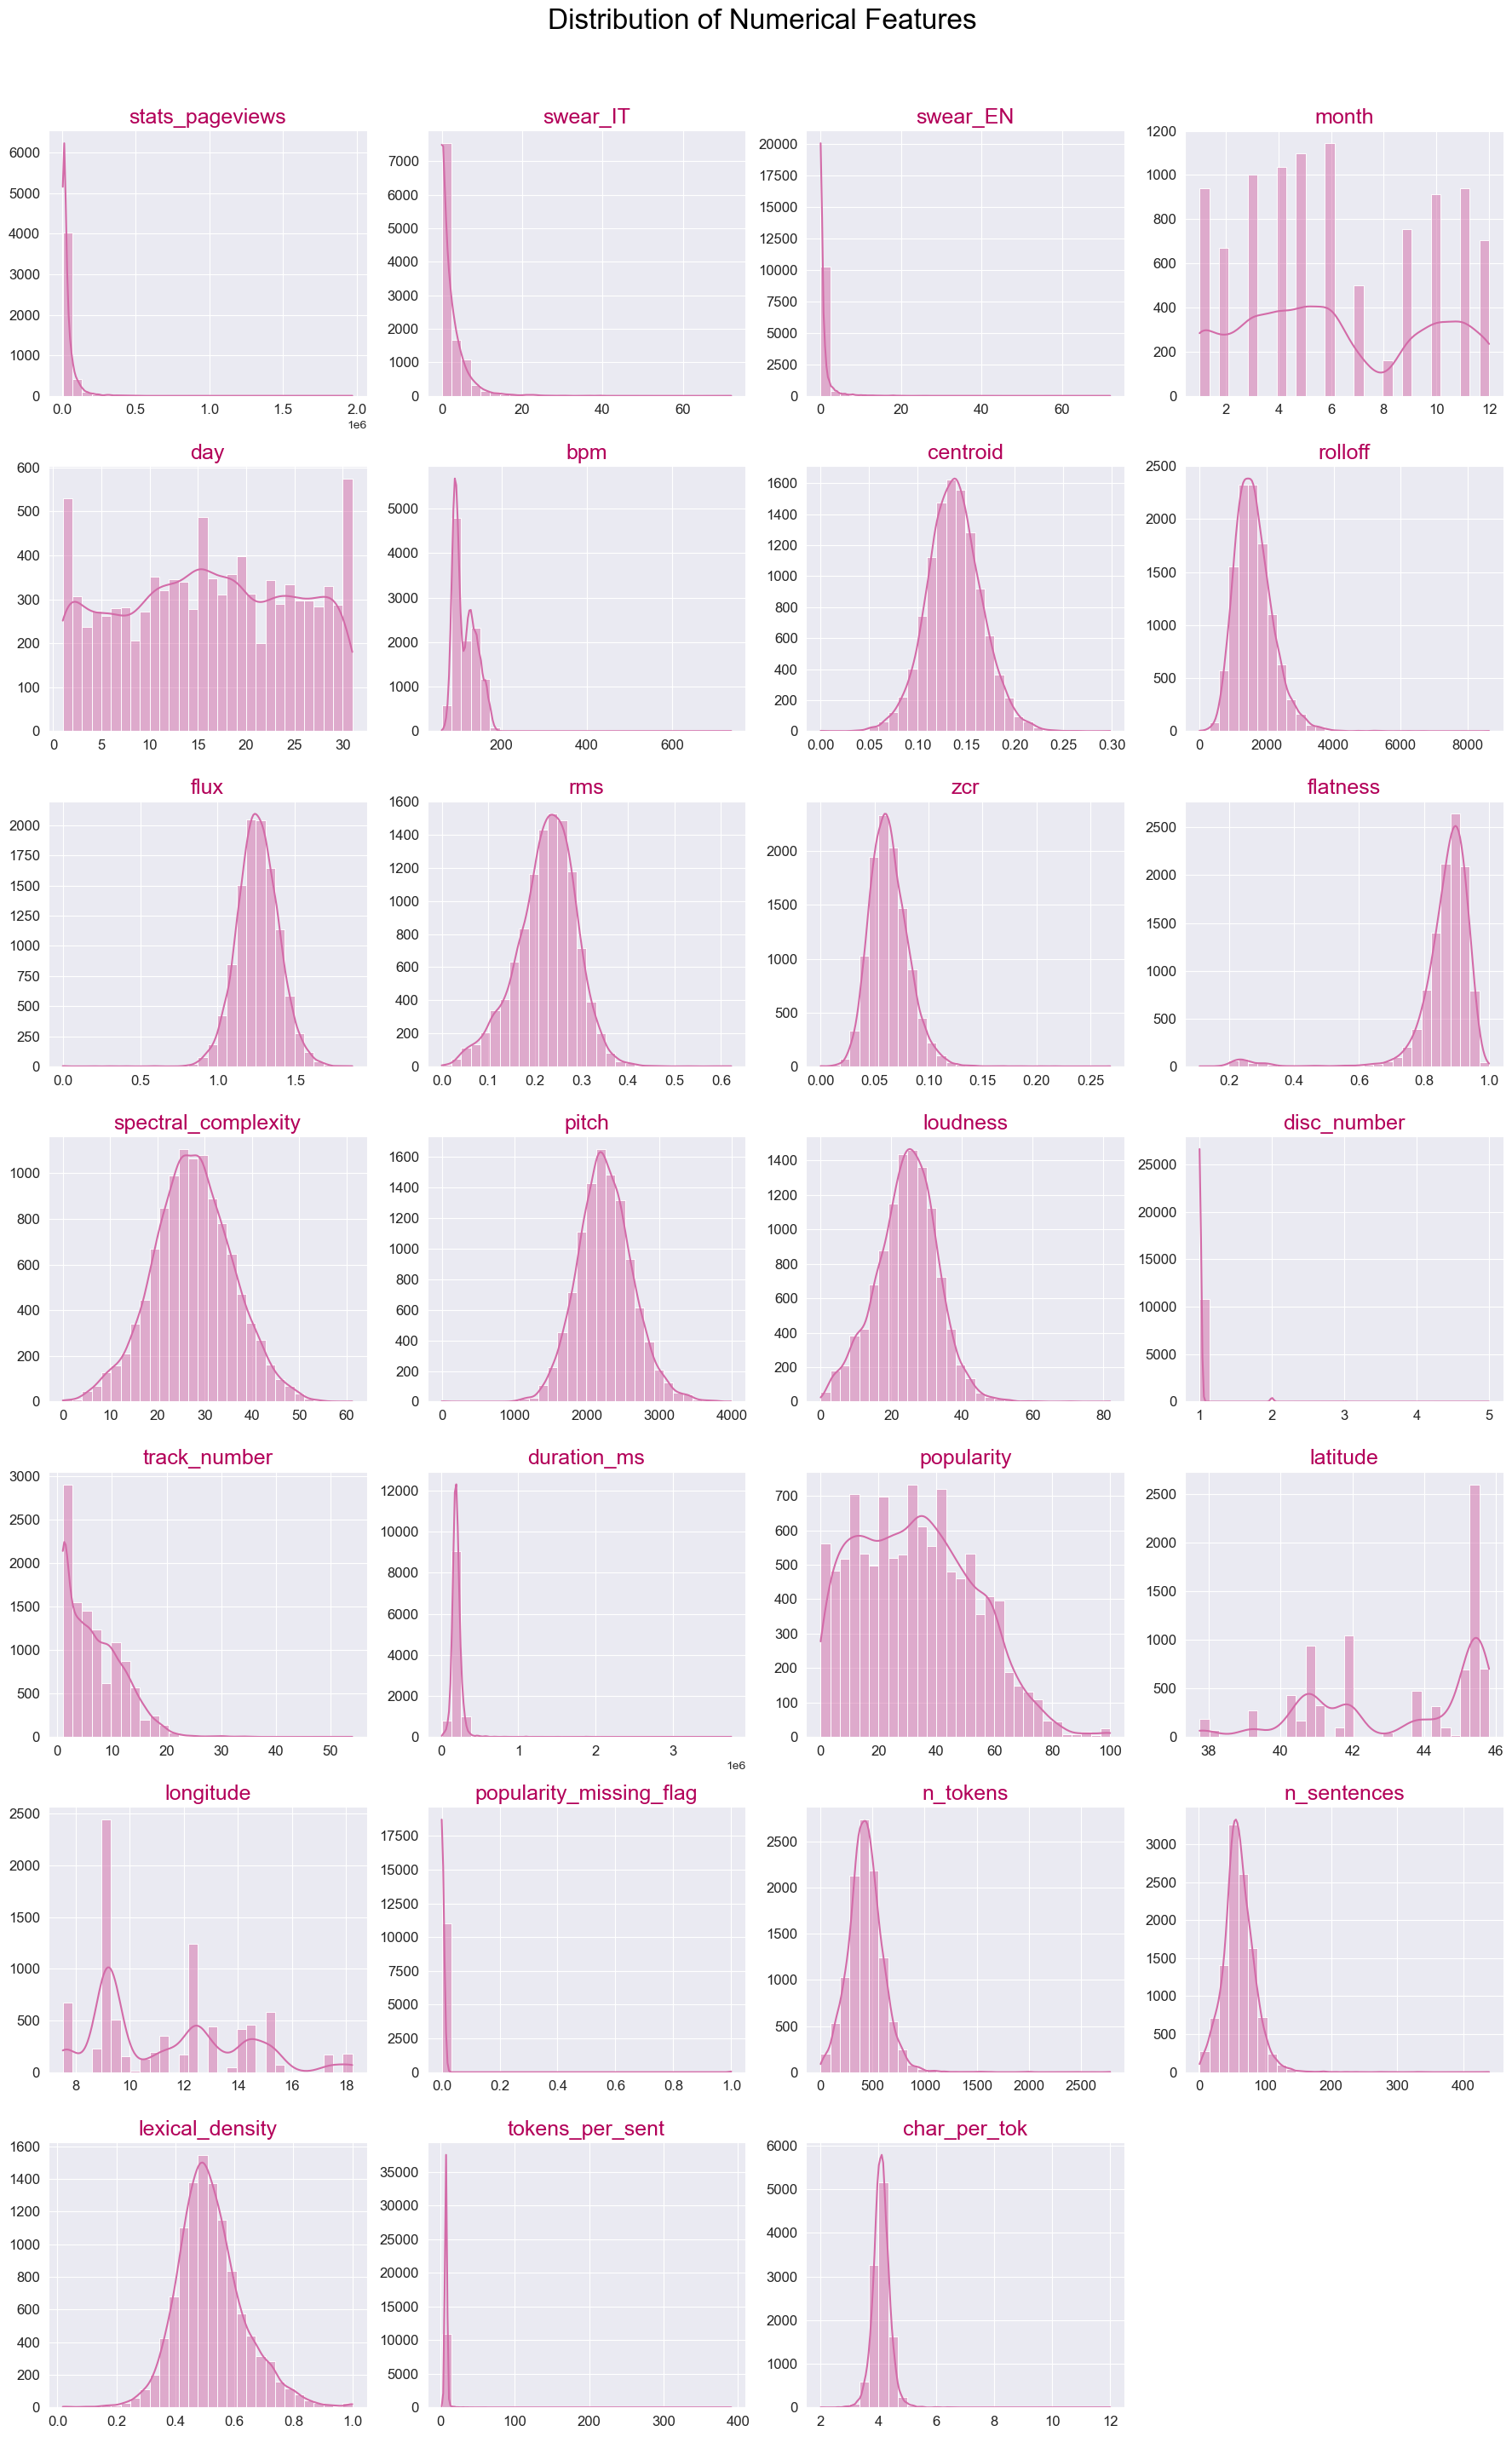

In [40]:
# Select numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# --- Summary statistics table ---
display(df[num_cols].describe().T.style.background_gradient(cmap='RdPu'))

# --- Histograms for each numeric column ---
n_cols = 4
n_rows = -(-len(num_cols) // n_cols)  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), bins=30, kde=True, color="#d36ba8", ax=axes[i])
    axes[i].set_title(col, fontsize=18, color="#b30059")   # larger title font
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='both', labelsize=12)          # larger tick labels

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Numerical Features", fontsize=24, color="#000000", y=1.02)  # larger main title
plt.tight_layout()
plt.show()


In [41]:
# Calculate basic statistics (mean and median)
statistics = df[num_cols].describe().T

# Calculate skewness
skews = df[num_cols].skew()

skew_analysis = pd.DataFrame({
    'mean': statistics['mean'],
    'median': statistics['50%'],
    'skewness_value': skews
})

# Define a function to classify skewness
# These are standard thresholds used in statistics:
# > +0.5 = Positive Skew (Right-tailed)
# < -0.5 = Negative Skew (Left-tailed)
# Between -0.5 and +0.5 = Substantially Symmetric
def classify_skew(skew_value):
    if skew_value > 0.5:
        return "Positive (Right Skew)"
    elif skew_value < -0.5:
        return "Negative (Left Skew)"
    else:
        return "Symmetric"

skew_analysis['skew_type'] = skew_analysis['skewness_value'].apply(classify_skew)

print("Skewness Analysis of Numerical Features")

display(skew_analysis.sort_values(by='skewness_value', ascending=False))

Skewness Analysis of Numerical Features


,mean,median,skewness_value,skew_type
tokens_per_sent,7.467191,7.258625,47.658478,Positive (Right Skew)
popularity_missing_flag,0.002538,0.000000,19.776473,Positive (Right Skew)
duration_ms,203890.062620,196760.000000,17.891438,Positive (Right Skew)
stats_pageviews,36999.539539,19100.000000,10.809589,Positive (Right Skew)
disc_number,1.016522,1.000000,10.199815,Positive (Right Skew)
swear_EN,0.719634,0.000000,10.103457,Positive (Right Skew)
swear_IT,2.371102,1.000000,4.402361,Positive (Right Skew)
char_per_tok,4.094184,4.091172,1.798241,Positive (Right Skew)
n_sentences,60.521211,59.000000,1.669030,Positive (Right Skew)
bpm,114.145935,106.980000,1.651301,Positive (Right Skew)


### Data Transformation

In [42]:
# Definizione delle Liste di Feature
features_positive_skew = [
    'tokens_per_sent', 'duration_ms', 'stats_pageviews',
    'disc_number', 'swear_EN', 'swear_IT', 'char_per_tok',
    'n_sentences', 'bpm', 'n_tokens', 'rolloff',
    'track_number', 'zcr', 'longitude', 'lexical_density'
]

features_negative_skew = ['latitude', 'flatness']

features_symmetric = [
    'popularity', 'pitch', 'month', 'centroid',
    'spectral_complexity', 'day', 'loudness', 'flux', 'rms'
]

# Filtra solo per le colonne che esistono
features_positive_skew = [col for col in features_positive_skew if col in df.columns]
features_negative_skew = [col for col in features_negative_skew if col in df.columns]
features_symmetric = [col for col in features_symmetric if col in df.columns]

# Applica la Trasformazione Logaritmica (per Asimmetria Positiva)
print(f"Applying log(x+1) transform to {len(features_positive_skew)} positively skewed features...")
for col in features_positive_skew:
    new_col_name = f"log_{col}"
    df[new_col_name] = np.log1p(df[col])

# Applica la Trasformazione "Riflessa" (per Asimmetria Negativa)
print(f"Applying reflected log(x+1) transform to {len(features_negative_skew)} negatively skewed features...")
for col in features_negative_skew:
    new_col_name = f"log_{col}_reflected"
    # 1. Rifletti i dati: (Max + 1) - x
    reflected_data = df[col].max() + 1 - df[col]
    # 2. Applica il log
    df[new_col_name] = np.log1p(reflected_data)

new_positive_cols = [f"log_{col}" for col in features_positive_skew if f"log_{col}" in df.columns]
new_negative_cols = [f"log_{col}_reflected" for col in features_negative_skew if f"log_{col}_reflected" in df.columns]
symmetric_cols = [col for col in features_symmetric if col in df.columns]

# Combina tutte le feature che ora dovrebbero essere (quasi) simmetriche
features_to_verify = new_positive_cols + new_negative_cols + symmetric_cols

print(f"Verifying {len(features_to_verify)} transformed/symmetric features...")

Applying log(x+1) transform to 15 positively skewed features...
Applying reflected log(x+1) transform to 2 negatively skewed features...


#### Check New Distribution

In [44]:
print("Skewness Analysis (AFTER Log Transform)")

statistics = df[features_to_verify].describe().T
skews = df[features_to_verify].skew()

skew_analysis_after = pd.DataFrame({
    'mean': statistics['mean'],
    'median': statistics['50%'],
    'skewness_value': skews
})

def classify_skew(skew_value):
    if skew_value > 0.5:
        return "Positive (Right Skew)"
    elif skew_value < -0.5:
        return "Negative (Left Skew)"
    else:
        return "Symmetric"

skew_analysis_after['skew_type'] = skew_analysis_after['skewness_value'].apply(classify_skew)

print("Risultati della nuova analisi di asimmetria:")
display(skew_analysis_after.sort_values(by='skewness_value', ascending=False))



--- Skewness Analysis (AFTER Log Transform) ---
Risultati della nuova analisi di asimmetria:


,mean,median,skewness_value,skew_type
log_disc_number,0.699696,0.693147,8.676223,Positive (Right Skew)
log_flatness_reflected,0.759430,0.750236,3.729822,Positive (Right Skew)
log_tokens_per_sent,2.104239,2.111258,2.550719,Positive (Right Skew)
log_swear_EN,0.275314,0.000000,2.442873,Positive (Right Skew)
log_zcr,0.061343,0.059871,0.709938,Positive (Right Skew)
log_swear_IT,0.851527,0.693147,0.577300,Positive (Right Skew)
log_stats_pageviews,9.975402,9.857496,0.554659,Positive (Right Skew)
popularity,32.859953,32.000000,0.338211,Symmetric
log_bpm,4.720945,4.681946,0.305646,Symmetric
log_longitude,2.491766,2.483717,0.285273,Symmetric


,count,mean,std,min,25%,50%,75%,max
log_tokens_per_sent,11032.000000,2.104239,0.210286,0.916291,2.002008,2.111258,2.207275,5.971262
log_duration_ms,10955.000000,12.179057,0.298782,9.343734,12.046394,12.189745,12.333498,15.138082
log_stats_pageviews,4641.000000,9.975402,0.974464,8.518592,9.173884,9.857496,10.646567,14.494157
log_disc_number,10955.000000,0.699696,0.053407,0.693147,0.693147,0.693147,0.693147,1.791759
log_swear_EN,11032.000000,0.275314,0.563024,0.000000,0.000000,0.000000,0.000000,4.290459
log_swear_IT,11032.000000,0.851527,0.805335,0.000000,0.000000,0.693147,1.386294,4.290459
log_char_per_tok,11032.000000,1.626346,0.059028,1.098612,1.594222,1.627508,1.660644,2.564949
log_n_sentences,11032.000000,4.027112,0.479179,0.693147,3.871201,4.094345,4.317488,6.086775
log_bpm,10970.000000,4.720945,0.222457,4.110382,4.531739,4.681946,4.909857,6.605663
log_n_tokens,11032.000000,5.979442,0.503871,1.098612,5.805135,6.061457,6.276643,7.931285


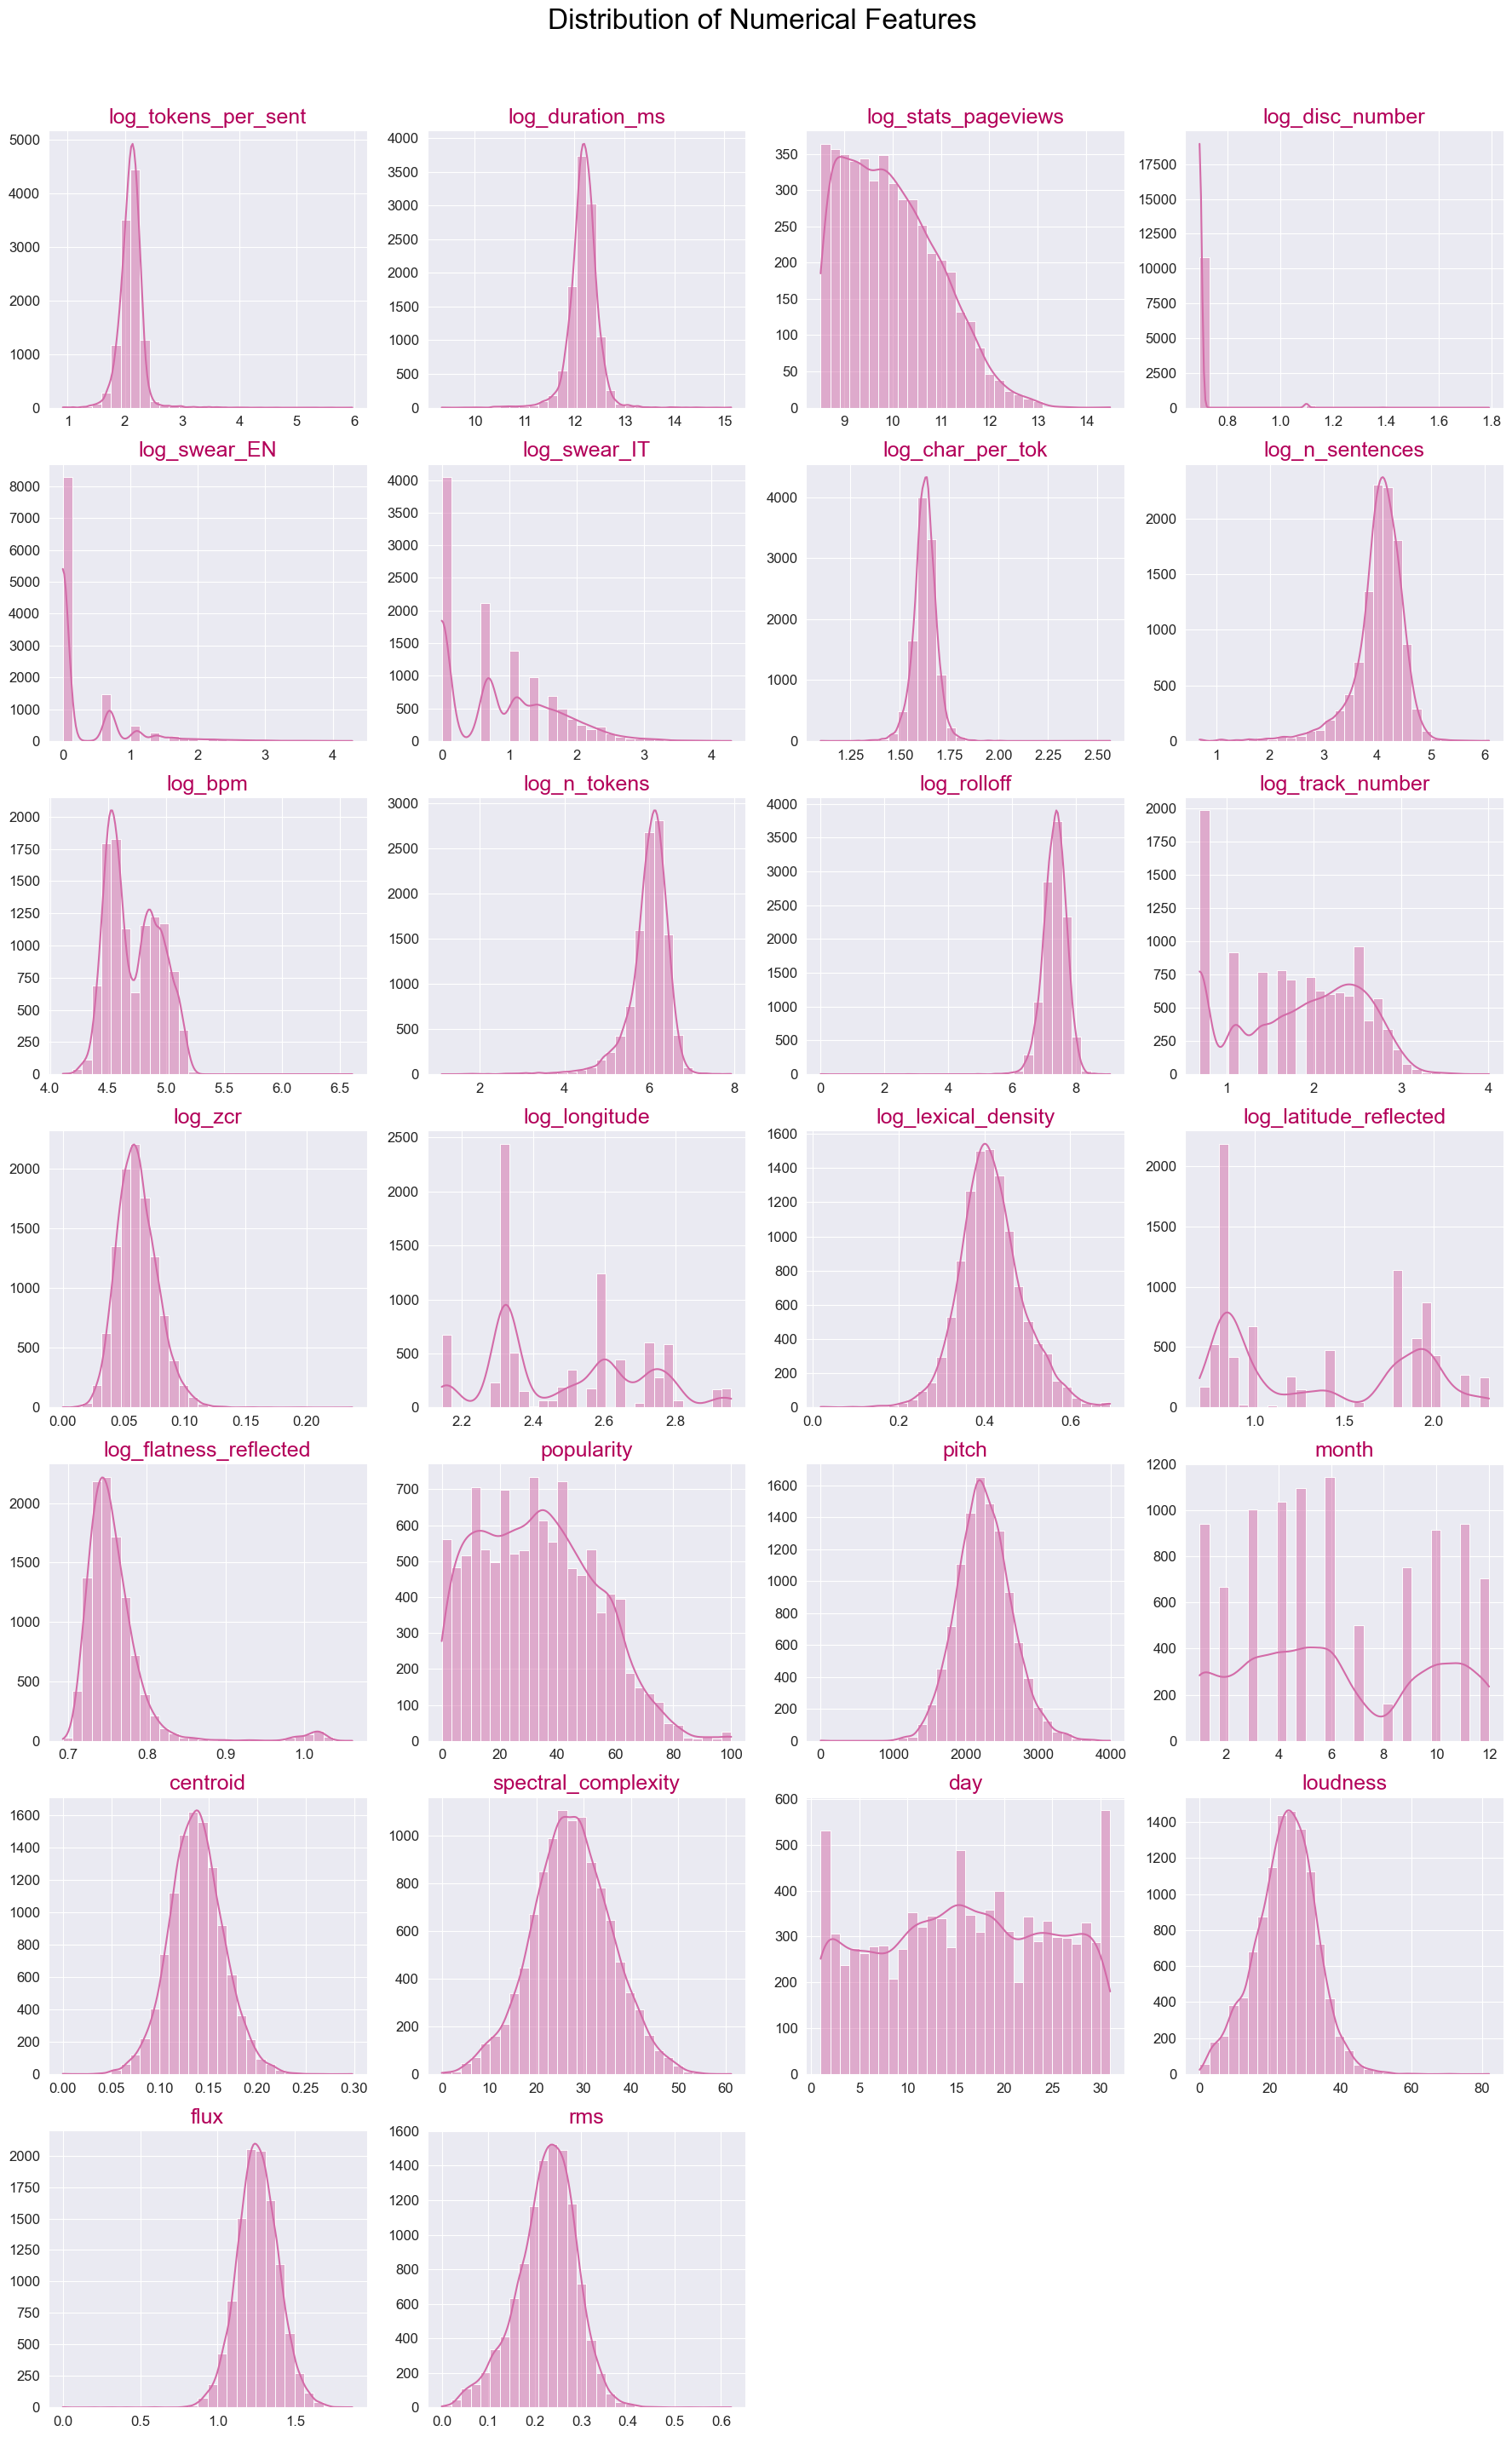

In [45]:
display(df[features_to_verify].describe().T.style.background_gradient(cmap='RdPu'))

#  Histograms for each numeric column
n_cols = 4
n_rows = -(-len(features_to_verify) // n_cols)  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features_to_verify):
    sns.histplot(df[col].dropna(), bins=30, kde=True, color="#d36ba8", ax=axes[i])
    axes[i].set_title(col, fontsize=18, color="#b30059")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='both', labelsize=12)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Numerical Features", fontsize=24, color="#000000", y=1.02)
plt.tight_layout()
plt.show()


#### Normalizzation

In [46]:
print(f"Shape prima della normalizzazione: {df.shape}")

# Aggiungiamo anche la colonna 'popularity_missing_flag' (che è 0 o 1)
features_symmetric.append('popularity_missing_flag')

# Creazione della Lista Finale di Tutte le Feature da Scalare
# 1. Le feature simmetriche originali
features_to_scale = [col for col in features_symmetric if col in df.columns]
# 2. Le *nuove* feature log-trasformate (positive)
features_to_scale += [f"log_{col}" for col in features_positive_skew if f"log_{col}" in df.columns]
# 3. Le *nuove* feature log-trasformate (negative)
features_to_scale += [f"log_{col}_reflected" for col in features_negative_skew if f"log_{col}_reflected" in df.columns]

print(f"Trovate {len(features_to_scale)} feature numeriche totali da normalizzare.")

scaler = StandardScaler()

df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\n--- Verifica: Statistiche DOPO la Normalizzazione ---")
print("Tutte le feature dovrebbero ora avere media (mean) ~0.0 e deviazione standard (std) ~1.0")
display(df[features_to_scale].describe().T)


Shape prima della normalizzazione: (11032, 70)
Trovate 27 feature numeriche totali da normalizzare.
Applicazione di StandardScaler...
Normalizzazione completata.

--- Verifica: Statistiche DOPO la Normalizzazione ---
Tutte le feature dovrebbero ora avere media (mean) ~0.0 e deviazione standard (std) ~1.0


,count,mean,std,min,25%,50%,75%,max
popularity,11032.0,1.262386e-16,1.000045,-1.647567,-0.845342,-0.043117,0.708969,3.366339
pitch,10970.0,2.992441e-16,1.000046,-5.946298,-0.662930,-0.036597,0.624006,4.583974
month,9865.0,-7.778876e-17,1.000051,-1.498055,-0.923336,-0.061259,1.088178,1.662897
centroid,10970.0,3.938104e-16,1.000046,-4.918041,-0.653903,-0.014639,0.628195,5.731590
spectral_complexity,10970.0,-4.326732e-16,1.000046,-3.276407,-0.656991,-0.010751,0.657259,4.018531
day,9740.0,-7.003296e-17,1.000051,-1.674406,-0.771633,0.018294,0.808221,1.710994
loudness,10970.0,-1.839509e-16,1.000046,-2.822061,-0.626623,0.049349,0.667048,6.694236
flux,10970.0,-5.078081e-16,1.000046,-9.271992,-0.637892,-0.016216,0.640232,4.489876
rms,10970.0,-9.586174e-17,1.000046,-3.497156,-0.583638,0.085957,0.674578,6.187060
popularity_missing_flag,11032.0,3.349186e-17,1.000045,-0.050443,-0.050443,-0.050443,-0.050443,19.824228


### Multivariate Analysis

In [47]:
print(f"Running IsolationForest on {len(df)} cleaned and transformed rows.")

# Preparazione dei Dati (Imputazione)
print(f"Using {len(features_to_scale)} cleaned, transformed, and scaled features.")

df_analysis = df[features_to_scale].fillna(0)
print(f"Data ready for analysis (NaNs filled with 0): {df_analysis.shape}")

# Applicazione di Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)

predictions = iso_forest.fit_predict(df_analysis)

df['is_outlier_multi'] = predictions

outliers_multi = df[df['is_outlier_multi'] == -1]
print(f"\nAnalysis completed.")
print(f"Number of multivariate outliers identified: {len(outliers_multi)}")

print("\nExamples of Multivariate Outliers (showing scaled values):")
display(outliers_multi[['full_title', 'primary_artist'] + features_to_scale].head())


pca = SklearnPCA(n_components=2, random_state=42)

data_scaled_2d = pca.fit_transform(df_analysis)

plot_df = pd.DataFrame(data_scaled_2d, columns=['PC1', 'PC2'])
plot_df['Type'] = np.where(predictions == -1, 'Outlier (-1)', 'Inlier (1)')

plot_df['original_index'] = df_analysis.index
plot_df = plot_df.merge(df[['full_title', 'primary_artist']], left_on='original_index', right_index=True, how='left')

chart = alt.Chart(plot_df).mark_circle(opacity=0.6).encode(
    x=alt.X('PC1', title='Principal Component 1'),
    y=alt.Y('PC2', title='Principal Component 2'),
    color=alt.Color('Type',
                    scale=alt.Scale(domain=['Outlier (-1)', 'Inlier (1)'],
                                    range=['red', 'blue'])),
    tooltip=['full_title', 'primary_artist', 'PC1', 'PC2', 'Type']
).properties(
    title='Isolation Forest Results (visualized with PCA)'
).interactive()

display(chart)

--- 3. Data Transformation: Multivariate Outlier Detection ---
Running IsolationForest on 11032 cleaned and transformed rows.
Using 27 cleaned, transformed, and scaled features.
Data ready for analysis (NaNs filled with 0): (11032, 27)

Analysis completed.
Number of multivariate outliers identified: 221

Examples of Multivariate Outliers (showing scaled values):


,full_title,primary_artist,popularity,pitch,month,centroid,spectral_complexity,day,loudness,flux,...,log_n_sentences,log_bpm,log_n_tokens,log_rolloff,log_track_number,log_zcr,log_longitude,log_lexical_density,log_latitude_reflected,log_flatness_reflected
1,POLKA by Rosa Chemical (Ft. Thelonious B.),Rosa Chemical,0.658830,-0.956266,-0.923336,2.478131,0.192050,-1.110173,-0.330048,0.687332,...,0.105237,0.671760,0.389850,2.179082,-0.598061,2.965720,-1.625164,-0.082526,-0.686845,1.838987
22,Freestyle #redbullnext #essemagazine by Rosa C...,Rosa Chemical,0.708969,-2.444194,-1.210696,-0.757471,0.521405,-0.997326,2.272204,0.549713,...,-2.491661,1.732926,-2.829354,0.091722,-0.993503,-0.408613,-1.625164,0.142923,-0.686845,2.128057
55,BRITISH PROV 2014 by Rosa Chemical,Rosa Chemical,0.257717,0.409717,-1.498055,3.320959,-1.258930,0.921068,-1.656687,0.766076,...,-2.050660,-0.832703,-2.237602,3.499321,-0.993503,6.492006,-1.625164,0.577920,-0.686845,5.462341
250,COVID-19 Freestyle by thasup,thasup,-1.396872,0.552206,-0.923336,2.899545,-2.191910,0.469681,-2.597437,0.650535,...,-1.237849,0.793877,-1.733650,3.842637,-1.550847,7.459528,0.429573,1.054654,0.834828,5.201910
263,I.B.F.M. rmx by thasup (Ft. Lazza & Low Kidd),thasup,1.310638,0.450362,-0.635977,2.506702,2.624590,-1.674406,2.439786,1.170101,...,0.792238,0.474029,0.301251,1.712703,-0.598061,1.954337,0.429573,-0.946970,0.834828,2.051532



Generating Altair scatter plot...


alt.Chart(...)

In [48]:
print("Final Multivariate Outlier Elimination ---")
print(f"Shape before final elimination: {df.shape}")

indices_to_drop = df[df['is_outlier_multi'] == -1].index
num_to_eliminate = len(indices_to_drop)

print(f"Found {num_to_eliminate} multivariate outliers to ELIMINATE.")

# Elimina queste righe "in-place"
if num_to_eliminate > 0:
    df.drop(indices_to_drop, inplace=True)
    print(f"SUCCESS: Removed {num_to_eliminate} multivariate outlier rows.")
    print(f"\nDataFrame shape AFTER final elimination: {df.shape}")
else:
    print("No multivariate outliers found to eliminate.")

if 'is_outlier_multi' in df.columns:
    df.drop(columns=['is_outlier_multi'], inplace=True)

print("\nMultivariate outliers removed.")

--- 4. Data Transformation: Final Multivariate Outlier Elimination ---
Shape before final elimination: (11032, 71)
Found 221 multivariate outliers to ELIMINATE.
SUCCESS: Removed 221 multivariate outlier rows.

DataFrame shape AFTER final elimination: (10811, 71)

Multivariate outliers removed.


### Correlation Analysis

 In this section we:
 - select numeric columns
 - compute Pearson and Spearman correlation matrices
 - detect highly correlated pairs (potentially redundant features)

In [ ]:
# Select only numeric columns (optionally exclude IDs)
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

print("Numeric columns used:", num_cols)

#### Pearson correlation (linear relationships)

In [ ]:
# =========================
# Column filters for Pearson
# =========================
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}

# =========================
# 1) Select numeric candidates (exclude id-like)
# =========================
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

excluded = {}
kept = []

for c in num_cols:
    s = df[c]
    reasons = []
    if pd.api.types.is_bool_dtype(s) or functions.is_binary_series(s):
        reasons.append("binary/bool → use point-biserial (not raw Pearson)")
    if functions.is_low_cardinal_int(s, max_levels=5):
        reasons.append("low-cardinality ordinal → prefer Spearman/Kendall")
    if functions.is_quasi_constant(s):
        reasons.append("quasi-constant → variance ~ 0")
    if functions.is_extreme_zeroinflated_count(s):
        reasons.append("extreme zero-inflated count")
    if reasons:
        excluded[c] = "; ".join(reasons)
    else:
        kept.append(c)

print("Columns kept for Pearson:", kept)
if excluded:
    print("\nColumns excluded and reason:")
    for k, v in excluded.items():
        print(f"- {k}: {v}")

# =========================
# 2) Pearson correlation (only 'kept' columns)
# =========================
if len(kept) < 2:
    raise ValueError("Too many columns excluded: fewer than 2 columns suitable for Pearson.")

pearson_corr = df[kept].corr(method="pearson")
print("\nPearson correlation (filtered):")
print(pearson_corr)

# =========================
# 3) Strong correlations (pair list, NOT matrix)
# =========================
threshold = 0.9  # adjust as needed

upper_mask = np.triu(np.ones(pearson_corr.shape), k=1).astype(bool)
pairs = (
    pearson_corr.where(upper_mask)
    .stack()
    .reset_index()
)
pairs.columns = ["feature_1", "feature_2", "pearson_r"]

strong_pearson = (
    pairs[pairs["pearson_r"].abs() >= threshold]
    .sort_values(by="pearson_r", key=lambda s: s.abs(), ascending=False)
)
print(f"\nStrong Pearson pairs (|r| >= {threshold}):")
print(strong_pearson if not strong_pearson.empty else "None")


In [ ]:
# ===== Custom palette =====

hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]  # your colors
cmap_custom = LinearSegmentedColormap.from_list("custom_purple", hex_colors)

# =========================
# Heatmap (Pearson matrix) with custom colors
# =========================
# Uses the same column order as `kept`
corr_mat = pearson_corr.loc[kept, kept]

# Mask NaNs to show as empty cells
data = np.ma.masked_invalid(corr_mat.to_numpy())

plt.figure(figsize=(8, 8))
# TwoSlopeNorm centers the color at 0, with vmin=-1, vmax=1
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
im = plt.imshow(data, aspect="auto", norm=norm, cmap=cmap_custom)
plt.colorbar(im, label="Pearson r")

plt.xticks(ticks=np.arange(len(kept)), labels=kept, rotation=90)
plt.yticks(ticks=np.arange(len(kept)), labels=kept)

# Optional grid
ax = plt.gca()
ax.set_xticks(np.arange(-.5, len(kept), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(kept), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

plt.title("Pearson correlation matrix (filtered)")
plt.tight_layout()
plt.show()


#### Spearman correlation (monotonic relationships, robust to outliers)

In [ ]:
# =========================
# Column filters for Spearman + Pearson vs Spearman comparison
# =========================

id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}

# Variables typically circular (Spearman is not recommended for cyclic relationships)
circular_names = {"month", "day", "weekday", "dow", "hour", "minute", "second"}

# =========================
# 1) Select numeric candidates for Spearman (keep ordinal/binary, exclude id-like)
# =========================
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

excluded_s = {}
kept_s = []
spearman_soft_warn = {}

for c in num_cols:
    s = df[c]
    reasons = []
    # Hard exclusions for Spearman suitability
    if functions.is_quasi_constant(s) or s.dropna().nunique() < 2:
        reasons.append("constant/nearly-constant or <2 distinct non-null values")
    if c.lower() in circular_names:
        reasons.append("circular variable (cyclic) — Spearman not suitable")
    if reasons:
        excluded_s[c] = "; ".join(reasons)
        continue

    # Keep the column
    kept_s.append(c)

    # Soft warnings (still kept, but flagged)
    warns = []
    if pd.api.types.is_integer_dtype(s) and (s >= 0).all() and (s == 0).mean() >= 0.95:
        warns.append("extreme zero-inflation (many ties) — Kendall τ-b or transformations may be better")
    if warns:
        spearman_soft_warn[c] = "; ".join(warns)

print("Columns kept for Spearman:", kept_s)
if excluded_s:
    print("\nColumns excluded for Spearman (hard) and reason:")
    for k, v in excluded_s.items():
        print(f"- {k}: {v}")
if spearman_soft_warn:
    print("\nColumns where Spearman is NOT recommended (soft warning):")
    for k, v in spearman_soft_warn.items():
        print(f"- {k}: {v}")

# =========================
# 2) Spearman correlation (only 'kept_s' columns)
# =========================
if len(kept_s) < 2:
    raise ValueError("Too few columns for Spearman: need at least 2 usable columns.")

# Use min_periods to reduce all-NaN issues with sparse overlap
spearman_corr = df[kept_s].corr(method="spearman", min_periods=3)
print("\nSpearman correlation (filtered):")
print(spearman_corr)

# =========================
# 3) Strong correlations (pair list, NOT matrix)
# =========================
threshold = 0.9  # adjust as needed

upper_mask_s = np.triu(np.ones(spearman_corr.shape), k=1).astype(bool)
pairs_s = (
    spearman_corr.where(upper_mask_s)
    .stack()
    .reset_index()
)
pairs_s.columns = ["feature_1", "feature_2", "spearman_rho"]

strong_spearman = (
    pairs_s[pairs_s["spearman_rho"].abs() >= threshold]
    .sort_values(by="spearman_rho", key=lambda s: s.abs(), ascending=False)
)

print(f"\nStrong Spearman pairs (|rho| >= {threshold}):")
print(strong_spearman if not strong_spearman.empty else "None")

# =========================
# 4) Pearson vs Spearman comparison on common pairs
#    (requires you already computed `pearson_corr` and `strong_pearson`)
# =========================
def _pairs_from_corr(corr_df: pd.DataFrame, val_name: str) -> pd.DataFrame:
    """Stack upper triangle of a correlation matrix into a tidy pair list."""
    mask = np.triu(np.ones(corr_df.shape), k=1).astype(bool)
    out = (
        corr_df.where(mask)
        .stack()
        .reset_index()
    )
    out.columns = ["feature_1", "feature_2", val_name]
    # Ensure consistent pair ordering (feature_1 < feature_2) to merge reliably
    ordered = out.apply(
        lambda r: pd.Series(sorted([r["feature_1"], r["feature_2"]]) + [r[val_name]]),
        axis=1
    )
    ordered.columns = ["f1", "f2", val_name]
    return ordered

try:
    # Intersect the variable sets so we're comparing apples to apples
    common_cols = sorted(set(pearson_corr.columns).intersection(set(spearman_corr.columns)))
    if len(common_cols) >= 2:
        p_pairs = _pairs_from_corr(pearson_corr.loc[common_cols, common_cols], "pearson_r")
        s_pairs = _pairs_from_corr(spearman_corr.loc[common_cols, common_cols], "spearman_rho")
        comp = p_pairs.merge(s_pairs, on=["f1", "f2"], how="inner")
        comp["abs_delta"] = (comp["pearson_r"] - comp["spearman_rho"]).abs()
        comp["sign_disagreement"] = np.sign(comp["pearson_r"]) != np.sign(comp["spearman_rho"])

        # Sort by absolute delta descending
        comp_sorted = comp.sort_values("abs_delta", ascending=False).reset_index(drop=True)

        print("\nPearson vs Spearman comparison (common pairs):")
        print(comp_sorted.head(30).to_string(index=False))

        # Optional: also show only sign disagreements
        comp_sign_flip = comp_sorted[comp_sorted["sign_disagreement"]]
        if not comp_sign_flip.empty:
            print("\nPairs with SIGN DISAGREEMENT between Pearson and Spearman:")
            print(comp_sign_flip.head(30).to_string(index=False))

        # Expose for later use (e.g., plotting)
        comparison_table = comp_sorted.copy()
    else:
        print("\nNot enough common columns for comparison.")
except NameError:
    print("\n`pearson_corr` not found. Run the Pearson block first to enable the comparison.")


In [ ]:
# Custom palette
cmap_custom = LinearSegmentedColormap.from_list("custom_purple", hex_colors)

# Ensure same column order as kept_s
corr_mat_s = spearman_corr.loc[kept_s, kept_s]

# Mask NaNs so they appear as empty cells
data_s = np.ma.masked_invalid(corr_mat_s.to_numpy())

plt.figure(figsize=(8, 8))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)  # center color at 0
im = plt.imshow(data_s, aspect="auto", norm=norm, cmap=cmap_custom)
plt.colorbar(im, label="Spearman ρ")

plt.xticks(ticks=np.arange(len(kept_s)), labels=kept_s, rotation=90)
plt.yticks(ticks=np.arange(len(kept_s)), labels=kept_s)

# Optional grid to separate cells
ax = plt.gca()
ax.set_xticks(np.arange(-.5, len(kept_s), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(kept_s), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

plt.title("Spearman correlation matrix (filtered)")
plt.tight_layout()
plt.show()

The two heatmaps display the Pearson and Spearman correlation matrices after filtering the dataset. In both cases, correlations are generally weak, indicating that the majority of variables are largely independent. Only small clusters of moderate correlation appear among acoustic features such as spectral centroid, rolloff, flux, flatness, and spectral complexity, which is expected since they describe related timbral properties. Linguistic features show minimal association with acoustic and popularity-related variables, and metrics like popularity, pageviews, and the two swearing indicators exhibit almost no meaningful relationship with the rest of the features. The similarity between the Pearson and Spearman matrices suggests that even non-linear monotonic trends are limited. Overall, the dataset shows low redundancy, with only a few mild correlations confined to subsets of acoustically related features.

###  Distance & similarity measures

 In this section we compute different distance/similarity matrices  on the numeric features to support clustering and nearest-neighbor analysis.


In [ ]:
# Riutilizziamo num_cols definiti prima.
# Se non li hai ancora:
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

print("Numeric columns used for distances:", num_cols)

# Standardizzazione (z-score)
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

X_num_df = pd.DataFrame(X_num, columns=num_cols)
display(X_num_df.head())

#### Euclidean distance

Standard choice for numeric features (after scaling). Used in k-means and many clustering methods.

In [ ]:
# --- Custom colors ---
hex_colors = ["#ffffff", "#e1bee7", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

X_sub = X_num  # <-- no subsampling

# (Optional) memory warning: full distance matrix is n x n
n = X_sub.shape[0]
bytes_per = 8  # float64 by default
est_gb = (n * n * bytes_per) / (1024**3)
if est_gb > 0.5:
    print(f"[Info] Full distance matrix size ~{est_gb:.2f} GB for n={n}. "
          "Consider subsampling for very large n.")

# Light diagnostics: rows where Euclidean is NOT ideal
row_has_bad = ~np.isfinite(X_sub).all(axis=1)
row_zero_ratio = (X_sub == 0).sum(axis=1) / np.maximum(1, X_sub.shape[1])
row_too_sparse = row_zero_ratio >= 0.95  # tweak threshold if needed
bad_idx = np.where(row_has_bad | row_too_sparse)[0]
if bad_idx.size:
    print(f"[Warning] {bad_idx.size} rows may be unsuitable for Euclidean distance.")
    print(" - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). Consider cosine/Jaccard or imputation/scaling.")
    print(" - Example indices:", bad_idx[:20].tolist(), ("..." if bad_idx.size > 20 else ""))

# Minimal NaN handling BEFORE distances (drop all-NaN cols + median-impute)
col_nan_counts = np.isnan(X_sub).sum(axis=0)
all_nan_cols = np.where(col_nan_counts == X_sub.shape[0])[0]
if all_nan_cols.size:
    print(f"Dropping {all_nan_cols.size} all-NaN columns:", all_nan_cols[:20].tolist(),
          ("..." if all_nan_cols.size > 20 else ""))
    X_sub = np.delete(X_sub, all_nan_cols, axis=1)

if np.isnan(X_sub).any():
    print("Median-imputing remaining NaN values column-wise.")
    X_sub = SimpleImputer(strategy="median").fit_transform(X_sub)

# Euclidean distance matrix (unchanged logic)
dist_euclidean = pairwise_distances(X_sub, metric="euclidean")

# Quick sanity checks
diag_max = np.abs(np.diag(dist_euclidean)).max()
sym_err = np.abs(dist_euclidean - dist_euclidean.T).max()
print(f"Diag max={diag_max:.3e} (should be ~0), symmetry max diff={sym_err:.3e} (should be ~0)")

# Small numeric preview (first 10x10)
dist_euclidean_df = pd.DataFrame(dist_euclidean)
display(dist_euclidean_df.iloc[:10, :10])

# ===== Plots (with custom colors) =====

# 1) Heatmap (distances >= 0 → 0..max)
plt.figure(figsize=(8, 7))
vmax = np.nanmax(dist_euclidean)
im = plt.imshow(dist_euclidean, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Euclidean distance")
plt.title("Euclidean distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram (upper triangle, no diagonal)
triu_vals = dist_euclidean[np.triu_indices(dist_euclidean.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Euclidean distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor)
k = 10
if dist_euclidean.shape[0] > k:
    D_sorted = np.sort(dist_euclidean, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({dist_euclidean.shape[0]}) for k={k} k-NN plot.")

The Euclidean-distance heatmap shows a uniform and noise-like structure, with no visible blocks or clusters, indicating that samples are spread fairly evenly in feature space and do not form distinct groups. The histogram confirms this homogeneous layout: the distribution of pairwise distances is unimodal and concentrated around values between roughly 1.2 and 1.6, suggesting that most samples lie at comparable Euclidean distances from each other, with only a small number of unusually close or distant pairs. The sorted 10-nearest-neighbor distance curve rises smoothly, showing that most points have neighbors at similar distances, while only a small fraction exhibit larger 10-NN distances and may be considered slightly more isolated. Overall, the dataset appears dense, continuous, and non-clustered when examined through Euclidean geometry.

#### Manhattan distance

More robust to outliers than Euclidean.

In [ ]:
# ============================================
# Manhattan (L1) distance: minimal-safe pipeline + clear plots
# ============================================

# --- Custom colors (same as before) ---
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# --------------------------------------------
# Use full dataset (no subsampling)
# NOTE: L1, like L2, benefits from comparable feature scales.
# --------------------------------------------
X_sub = X_num  # no subsampling

# (Optional) memory warning: full distance matrix is n x n
n = X_sub.shape[0]
bytes_per = 8  # float64 by default
est_gb = (n * n * bytes_per) / (1024**3)
if est_gb > 0.5:
    print(f"[Info] Full distance matrix size ~{est_gb:.2f} GB for n={n}. "
          "Consider subsampling for very large n.")

# --------------------------------------------
# Light diagnostics: rows where Manhattan may be unsuitable
# - NaN/Inf present
# - extreme sparsity (>=95% zeros): consider cosine/Jaccard for sparse sets
# --------------------------------------------
row_has_bad = ~np.isfinite(X_sub).all(axis=1)
row_zero_ratio = (X_sub == 0).sum(axis=1) / np.maximum(1, X_sub.shape[1])
row_too_sparse = row_zero_ratio >= 0.95
bad_idx = np.where(row_has_bad | row_too_sparse)[0]
if bad_idx.size:
    print(f"[Warning] {bad_idx.size} rows may be unsuitable for Manhattan distance.")
    print(" - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). "
          "Consider cosine/Jaccard or imputation/scaling.")
    print(" - Example indices:", bad_idx[:20].tolist(), ("..." if bad_idx.size > 20 else ""))

# --------------------------------------------
# Minimal NaN handling BEFORE distances
# - Drop columns that are entirely NaN
# - Median-impute remaining NaNs column-wise
# (No scaling here, to keep parity with your Euclidean cell.)
# --------------------------------------------
col_nan_counts = np.isnan(X_sub).sum(axis=0)
all_nan_cols = np.where(col_nan_counts == X_sub.shape[0])[0]
if all_nan_cols.size:
    print(f"Dropping {all_nan_cols.size} all-NaN columns:",
          all_nan_cols[:20].tolist(), ("..." if all_nan_cols.size > 20 else ""))
    X_sub = np.delete(X_sub, all_nan_cols, axis=1)

if np.isnan(X_sub).any():
    print("Median-imputing remaining NaN values column-wise.")
    X_sub = SimpleImputer(strategy="median").fit_transform(X_sub)

# --------------------------------------------
# Manhattan distance matrix (L1)
# --------------------------------------------
dist_manhattan = pairwise_distances(X_sub, metric="manhattan")

# Sanity checks: diagonal ~0, symmetry ~0
diag_max = np.abs(np.diag(dist_manhattan)).max()
sym_err = np.abs(dist_manhattan - dist_manhattan.T).max()
print(f"Diag max={diag_max:.3e} (should be ~0), symmetry max diff={sym_err:.3e} (should be ~0)")

# Small numeric preview (first 10x10)
dist_manhattan_df = pd.DataFrame(dist_manhattan)
display(dist_manhattan_df.iloc[:10, :10])

# ============================================
# Plots (with custom colors)
# ============================================

# 1) Heatmap (distances >= 0 → 0..max)
plt.figure(figsize=(8, 7))
vmax = np.nanmax(dist_manhattan)
im = plt.imshow(dist_manhattan, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Manhattan (L1) distance")
plt.title("Manhattan distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise distances (upper triangle, no diagonal)
triu_vals = dist_manhattan[np.triu_indices(dist_manhattan.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Manhattan distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise Manhattan distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor) – handy for DBSCAN eps guess
k = 10  # adjust if desired
if dist_manhattan.shape[0] > k:
    D_sorted = np.sort(dist_manhattan, axis=1)   # per-row sorted distances
    kth_sorted = np.sort(D_sorted[:, k])         # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (L1)")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({dist_manhattan.shape[0]}) for k={k} k-NN plot.")


The Manhattan-distance heatmap shows a uniformly dark and homogeneous pattern, indicating that pairwise L1 distances across samples do not form clear clusters or block structures; the dataset appears highly dispersed and lacks obvious grouping in feature space. The histogram confirms this by showing a unimodal distribution centered around moderate distances, with most pairwise distances concentrated between roughly 15 and 35, and only a small tail of larger values. The sorted 10-nearest-neighbor distance curve increases gradually for most samples and rises sharply only at the very end, meaning that the vast majority of points have reasonably close neighbors, while a small fraction of samples are more isolated. Overall, the three plots suggest a dataset with no strong clustering, a fairly consistent density, and only a limited number of potential outliers or sparsely located points.

#### Cosine similarity

Measures how similar the "shape" of feature vectors is, ignoring magnitude. Good for "profiles" (audio features, etc.).

In [ ]:
# ===== Custom colors =====
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# ------- 0) Pick the data matrix for cosine (sparse/text-like preferred) -------
X_cos = None
source = None

# Highest priority: user already has TF-IDF or a sparse text matrix
if "X_tfidf" in globals():
    X_cos = globals()["X_tfidf"]
    source = "X_tfidf"
elif "X_sparse" in globals():
    X_cos = globals()["X_sparse"]
    source = "X_sparse"
# Next: try to auto-select sparse/count-like columns from df (non-negative, high sparsity)
elif "df" in globals():
    # Heuristic: numeric non-negative columns with high zero ratio (>=80%) are text/count-like
    cand = []
    for c in df.select_dtypes(include=[np.number]).columns:
        s = df[c]
        if (s.dropna() >= 0).all():  # non-negative
            zero_ratio = (s == 0).mean()
            if zero_ratio >= 0.80:
                cand.append(c)
    if len(cand) >= 2:
        mat = df[cand].fillna(0.0).to_numpy(dtype=np.float32)
        if sparse is not None:
            X_cos = sparse.csr_matrix(mat)
            source = f"auto-selected {len(cand)} sparse/count-like cols from df"
        else:
            X_cos = mat
            source = f"auto-selected {len(cand)} dense count-like cols from df"
            print("[Info] SciPy not available: using dense matrix for cosine (works, but less memory-efficient).")
# Fallback: use X_num but warn (cosine may not be the best if dense & scaled)
if X_cos is None and "X_num" in globals():
    X_cos = np.asarray(X_num)
    source = "X_num (fallback)"
    print("[Warning] Using cosine on X_num (dense). Cosine is typically best for TF-IDF/sparse or embeddings; "
          "ensure direction matters more than magnitude.")

if X_cos is None:
    raise NameError("No suitable matrix found for cosine. Provide X_tfidf/X_sparse, or ensure df/X_num exist.")

print(f"[Cosine] Using matrix from: {source} | shape={X_cos.shape}")

# ------- 1) Minimal cleaning & row-norm guard -------
# Cosine requires non-zero rows; remove all-zero rows and report them.
if (sparse is not None) and hasattr(sparse, "issparse") and sparse.issparse(X_cos):
    row_norms = np.sqrt(X_cos.multiply(X_cos).sum(axis=1)).A.ravel()
    zero_rows = np.where(row_norms == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (cosine undefined).")
        mask = np.ones(X_cos.shape[0], dtype=bool); mask[zero_rows] = False
        X_cos = X_cos[mask]
else:
    # Dense: check NaN/Inf and zero rows
    if not np.isfinite(X_cos).all():
        print("[Info] Replacing NaN/Inf with 0 for cosine (better to impute upstream if needed).")
        X_cos = np.nan_to_num(X_cos, copy=False)
    row_norms = np.linalg.norm(X_cos, axis=1)
    zero_rows = np.where(row_norms == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (cosine undefined).")
        X_cos = np.delete(X_cos, zero_rows, axis=0)

# Optional: ensure unit-norm rows (pairwise_distances with 'cosine' can handle it, but normalization helps numerics)
Xn = normalize(X_cos, norm="l2", axis=1, copy=False)

# ------- 2) Cosine distance matrix -------
# Note: cosine distance = 1 - cosine similarity
D_cosine = pairwise_distances(Xn, metric="cosine")  # tipicamente in [0, 1] con TF-IDF

# Sanity checks
diag_max = np.abs(np.diag(D_cosine)).max()
sym_err = np.abs(D_cosine - D_cosine.T).max()
print(f"[Cosine] Diag max={diag_max:.3e} (≈0 expected), symmetry max diff={sym_err:.3e} (≈0 expected)")

# Small numeric preview (first 10x10)
D_cosine_df = pd.DataFrame(D_cosine)
display(D_cosine_df.iloc[:10, :10])

# ------- 3) Plots (heatmap + histogram + k-NN) -------
# 1) Heatmap
plt.figure(figsize=(8, 7))
vmax = np.nanmax(D_cosine)
im = plt.imshow(D_cosine, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Cosine distance (1 - cosine similarity)")
plt.title("Cosine distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise cosine distances (upper triangle, no diagonal)
triu_vals = D_cosine[np.triu_indices(D_cosine.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Cosine distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise cosine distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor) – handy for DBSCAN eps
k = 10
if D_cosine.shape[0] > k:
    D_sorted = np.sort(D_cosine, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (cosine)")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({D_cosine.shape[0]}) for k={k} k-NN plot.")


The cosine-distance heatmap shows a highly uniform and noise-like pattern, with no visible blocks or structured regions, indicating that samples do not form clear directional clusters in the feature space. This suggests that the angles between feature vectors vary smoothly across the dataset, with no strong grouping by orientation. The histogram reinforces this impression: cosine distances follow a roughly symmetric, bell-shaped distribution centered around 1.0, meaning that most pairs of samples are neither strongly similar nor strongly dissimilar in direction, but lie in a broad intermediate range. The sorted 10-nearest-neighbor distance curve rises gradually and remains low for most samples, showing that each point has reasonably close neighbors in terms of vector orientation, while only a small number of samples appear more isolated. Overall, cosine geometry paints a picture of a dataset that is dense, smoothly distributed, and lacking clear directional clusters.

#### Jaccard distance (binary features only)

Use this only on {0,1} columns (e.g., explicit flags, binary tags).

In [ ]:
# ============================================
# Jaccard distance: use only where it is ideal/better
# - Binary Jaccard for sets / 0-1 indicators (ideal)
# - Weighted Jaccard (Tanimoto) for non-negative counts/weights
# ============================================

# ---- Custom colors ----
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# ---------- 0) Pick a suitable matrix for Jaccard ----------
X_jac = None
source = None
mode = None  # "binary" or "weighted"

# Priority 1: explicit binary matrices
for name in ("X_bool", "X_binary"):
    if name in globals():
        X_jac = globals()[name]
        source = name
        mode = "binary"
        break

# Priority 2: explicit counts matrix for weighted jaccard
if X_jac is None and "X_counts" in globals():
    X_jac = np.asarray(globals()["X_counts"])
    source = "X_counts"
    mode = "weighted"

# Priority 3: auto-select sparse/count-like columns from df
if X_jac is None and "df" in globals():
    num_cols = df.select_dtypes(include=[np.number]).columns
    # Heuristic: non-negative & very sparse → treat as set presence (binary Jaccard)
    cand_sparse = []
    for c in num_cols:
        s = df[c]
        if (s.dropna() >= 0).all():
            zero_ratio = (s == 0).mean()
            if zero_ratio >= 0.80:
                cand_sparse.append(c)
    if len(cand_sparse) >= 2:
        mat = df[cand_sparse].fillna(0.0).to_numpy()
        # If values are exactly 0/1 (or can be binarized), use binary mode
        # We'll binarize by presence: >0 -> 1
        X_jac = (mat > 0).astype(np.uint8)
        source = f"auto-selected {len(cand_sparse)} sparse cols from df"
        mode = "binary"
    else:
        # If we have many non-negative columns but not sparse enough, use weighted
        cand_nonneg = [c for c in num_cols if (df[c].dropna() >= 0).all()]
        if len(cand_nonneg) >= 2:
            X_jac = df[cand_nonneg].fillna(0.0).to_numpy()
            source = f"auto-selected {len(cand_nonneg)} non-negative cols from df"
            mode = "weighted"

# Final safety: do not fallback to arbitrary dense numeric (Jaccard not ideal)
if X_jac is None:
    raise NameError(
        "No suitable matrix for Jaccard. Provide a binary indicator matrix (X_bool/X_binary) "
        "or non-negative counts (X_counts), or ensure df has non-negative sparse/count-like columns."
    )

print(f"[Jaccard] Using matrix from: {source} | shape={getattr(X_jac, 'shape', None)} | mode={mode}")

# ---------- 1) Clean/validate rows ----------
# Remove all-zero rows (Jaccard undefined)
def _row_l2_norm(a):
    return np.sqrt((a * a).sum(axis=1)) if a.ndim == 2 else np.linalg.norm(a, axis=1)

if sparse is not None and hasattr(sparse, "issparse") and sparse.issparse(X_jac):
    row_sums = X_jac.sum(axis=1).A.ravel() if mode == "binary" else X_jac.multiply(1).sum(axis=1).A.ravel()
    zero_rows = np.where(row_sums == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (Jaccard undefined).")
        mask = np.ones(X_jac.shape[0], dtype=bool); mask[zero_rows] = False
        X_jac = X_jac[mask]
else:
    X_jac = np.asarray(X_jac)
    if mode == "binary":
        # Ensure binary {0,1}
        X_jac = (X_jac > 0).astype(np.uint8)
        row_sums = X_jac.sum(axis=1)
    else:
        # Weighted: ensure non-negative
        if (X_jac < 0).any():
            raise ValueError("Weighted Jaccard requires non-negative values.")
        row_sums = X_jac.sum(axis=1)
    zero_rows = np.where(row_sums == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (Jaccard undefined).")
        X_jac = np.delete(X_jac, zero_rows, axis=0)

# ---------- 2) Distance computation ----------
def weighted_jaccard_distance(X):
    """
    Compute weighted Jaccard/Tanimoto distance for non-negative X (n x d).
    distance_ij = 1 - sum_k min(xik, xjk) / sum_k max(xik, xjk)
    """
    # Efficient but memory-heavy O(n^2 d); for large n consider chunking.
    X = np.asarray(X)
    n, d = X.shape
    # Broadcast min/max across pairs
    X_i = X[:, None, :]           # (n,1,d)
    X_j = X[None, :, :]           # (1,n,d)
    num = np.minimum(X_i, X_j).sum(axis=2)  # (n,n)
    den = np.maximum(X_i, X_j).sum(axis=2)  # (n,n)
    sim = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den!=0)
    return 1.0 - sim

if mode == "binary":
    # scikit-learn jaccard expects boolean/binary
    if sparse is not None and hasattr(sparse, "issparse") and sparse.issparse(X_jac):
        Xb = X_jac.astype(bool)
    else:
        Xb = X_jac.astype(bool)
    D_jaccard = pairwise_distances(Xb, metric="jaccard")
else:
    # Weighted Jaccard
    D_jaccard = weighted_jaccard_distance(X_jac)

# Sanity checks
diag_max = np.abs(np.diag(D_jaccard)).max()
sym_err = np.abs(D_jaccard - D_jaccard.T).max()
print(f"[Jaccard] Diag max={diag_max:.3e} (≈0), symmetry max diff={sym_err:.3e} (≈0)")

# Preview 10x10
D_jaccard_df = pd.DataFrame(D_jaccard)
display(D_jaccard_df.iloc[:10, :10])

# ---------- 3) Plots (heatmap + histogram + k-NN) ----------
# 1) Heatmap
plt.figure(figsize=(8, 7))
vmax = np.nanmax(D_jaccard)
im = plt.imshow(D_jaccard, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label=("Jaccard distance (binary)" if mode=="binary" else "Weighted Jaccard distance"))
plt.title("Jaccard distance heatmap" + ("" if mode=="binary" else " (weighted)"))
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise distances (upper triangle, no diagonal)
triu_vals = D_jaccard[np.triu_indices(D_jaccard.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Jaccard distance" + ("" if mode=="binary" else " (weighted)"))
plt.ylabel("Count")
plt.title("Distribution of pairwise Jaccard distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor)
k = 10
if D_jaccard.shape[0] > k:
    D_sorted = np.sort(D_jaccard, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (Jaccard{' weighted' if mode=='weighted' else ''})")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({D_jaccard.shape[0]}) for k={k} k-NN plot.")

The weighted-Jaccard heatmap shows a mostly uniform pattern with faint grid-like structures, suggesting that samples share similar sets of non-zero features and do not form well-defined clusters. A few bright horizontal and vertical lines indicate isolated samples whose feature composition differs noticeably from the rest, but these cases are rare. The 10-nearest-neighbor distance curve remains close to zero for the majority of points and increases sharply only at the far right, meaning that most samples have extremely similar neighbors in terms of weighted feature overlap, while a small subset appears more distinct. The histogram confirms this interpretation: Jaccard distances are concentrated between 0.1 and 0.4, showing substantial feature overlap across pairs, with a long tail toward higher distances and a small peak at 1.0 corresponding to pairs with disjoint or nearly disjoint feature sets. Overall, the dataset appears highly redundant under the weighted-Jaccard metric, with only a few structurally unusual or sparse samples standing out.